## Example 3 - Meshes for Surface Process Models

This notebook introduces the `QuagMesh` object, which builds upon the `QuagMesh` and introduces methods for finding the stream connectivity, catchment identification and handling local minima.

Here we demonstrate the stream flow components of the `QuagMesh` 

> Note: Again, the API for the structured mesh is identical

#### Contents

- [Upstream area and stream power](#Upstream-area-and-stream-power)
- [Outflow analysis](#Outflow analysis)

In [1]:
from quagmire.tools import meshtools
from quagmire import QuagMesh, QuagMesh
from quagmire import function as fn

In [2]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [3]:
minX, maxX = -5.0, 5.0
minY, maxY = -5.0, 5.0,
dx, dy = 0.02, 0.02

x, y, simplices = meshtools.elliptical_mesh(minX, maxX, minY, maxY, dx, dy, random_scale=1.0)

DM = meshtools.create_DMPlex_from_points(x, y, bmask=None)

mesh = QuagMesh(DM, downhill_neighbours=1)

print ("Triangulation has {} points".format(mesh.npoints))

Underlying Mesh type: TriMesh
0 - Delaunay triangulation 0.17651651799997126s
0 - Calculate node weights and area 0.006466622000004918s
0 - Find boundaries 0.0016405049999548282s


0 - cKDTree 0.013644146999979512s


0 - Construct neighbour cloud arrays 0.4051849179999749s, (0.22584348999998838s + 0.1792997279999895s)
0 - Construct rbf weights 0.04081044299999803s
Triangulation has 62234 points


## Height field and Rainfall

We generate the usual cylindrically symmetry domed surface and add multiple channels incised along the boundary. Here is it interesting to leave out the random noise to see how discretisation error influences the surface flow paths.

The `QuagMesh` stores a rainfall pattern that is used to compute the stream power assuming everything goes into the surface runoff it also records a sediment distribution pattern (etc).

In [4]:
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x) + 0.1

height  = np.exp(-0.025*(x**2 + y**2)**2) + 0.25 * (0.2*radius)**4  * np.cos(5.0*theta)**2 
height  += 0.5 * (1.0-0.2*radius)
heightn  = height + np.random.random(height.size) * 0.01 # random noise

with mesh.deform_topography():
    mesh.topography.data = height

0 - Build downhill matrices 0.05049207599995498s


0 - Build upstream areas 0.10374706300001435s


In [5]:
boundary_mask_fn = fn.misc.levelset(mesh.mask, 0.5)

AttributeError: module 'quagmire.function.misc' has no attribute 'levelset'

In [6]:
rainfall = mesh.add_variable(name="Rainfall")
rainfall.data = (mesh.topography**2).evaluate(mesh)
mesh.cumulative_flow(rainfall.data)**2

array([5.01931816, 5.02341623, 5.03617816, ..., 2.66829351, 2.3281053 ,
       3.99135784])

In [7]:
(mesh.upstream_integral_fn((mesh.topography**2))**2).evaluate(mesh)

array([1.15501106e-05, 1.69348645e-05, 7.48535258e-06, ...,
       4.44709461e-06, 3.86745508e-06, 7.02558358e-06])

In [8]:
# rbf1  = mesh.build_rbf_smoother(1.0, 1)
# rbf01 = mesh.build_rbf_smoother(0.1, 1)
# rbf001 = mesh.build_rbf_smoother(0.01, 1)

# print(rbf1.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))
# print(rbf01.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))
# print(rbf001.smooth_fn(rainfall, iterations=1).evaluate(0.0,0.0))

In [9]:
# rbf001.smooth_fn(rainfall, iterations=1).evaluate(mesh)

In [10]:
rainfall.evaluate(mesh)

array([2.24038348, 2.24129789, 2.24414308, ..., 0.47308102, 0.42065372,
       0.36434709])

## Upstream area and stream power

Integrating information upstream is a key component of stream power laws that are often used in landscape evolution models. This is computed by multiple $\mathbf{D} \cdot \mathbf{A}_{\mathrm{upstream}}$ evaluations to accumulate the area downstream node-by-node on the mesh. 

A `QuagMesh` object has a cumulative_flow method that computes this operation. There is also a quagmire function wrapper of this method that can be used as an operator to compute the area-weighted sum. This function is the numerical approximation of the upstream integral:

```python
upstream_precipitation_integral_fn = mesh.upstream_integral_fn(rainfall_pattern)
```



<!--
NOTE: rbf_smooth / streamwise_smooth need to be a function on the mesh ... 


This is handled by the `cumulative_flow(vector)` routine.

In [derivatives and hill slopes](#Derivatives-and-hill-slopes) we smoothed the entire landscape, however we can also target the RBF kernel to smooth just the streams:

```python
streamwise_smoothing(data, its, centre_weight=0.75)
```

where `its` indicates the number of iterations to smooth the field stream-wise. Increasing `its` smooths the field further afield upstream and downstream.
-->

In [11]:
rainfall_fn = (mesh.topography**2.0)
upstream_precipitation_integral_fn = mesh.upstream_integral_fn(rainfall_fn)
stream_power_fn = upstream_precipitation_integral_fn**2 * mesh.slope**1.0 * boundary_mask_fn

stream_power_fn.evaluate(mesh)

NameError: name 'boundary_mask_fn' is not defined

#### Tools: stream power smoothing

It may be that some smoothing is helpful in stabilizing the effect of the stream power term in the topography evolution equation. The following examples may be helpful.

Note that we provide an operator called `streamwise_smoothing_fn` which is conservative, a centre weighted smoothing kernel that only operates on nodes that are connected to each other in the stream network.

In [12]:
## We can apply some smoothing to this if necessary

rbf_smoother = mesh.build_rbf_smoother(0.05, 1)
rbf_smooth_str_power_fn = rbf_smoother.smooth_fn(stream_power_fn)
print(rbf_smooth_str_power_fn.evaluate(mesh))

str_smooth_str_power_fn = mesh.streamwise_smoothing_fn(stream_power_fn)
print(str_smooth_str_power_fn.evaluate(mesh))

NameError: name 'stream_power_fn' is not defined

In [13]:
## We could also smooth the components that make up the stream power

rbf_smoothed_slope_fn = rbf_smoother.smooth_fn(mesh.slope)
rbf_smooth_str_power_fn2 = upstream_precipitation_integral_fn**2 * rbf_smoothed_slope_fn**1.0 * boundary_mask_fn
print(rbf_smooth_str_power_fn2.evaluate(mesh))

str_smoothed_slope_fn = mesh.streamwise_smoothing_fn(mesh.slope)
str_smooth_str_power_fn2 = upstream_precipitation_integral_fn**2 * str_smoothed_slope_fn**1.0 * boundary_mask_fn
print(str_smooth_str_power_fn2.evaluate(mesh))

NameError: name 'boundary_mask_fn' is not defined

In [14]:
import lavavu

points = np.column_stack([mesh.tri.points, height])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[800,600], near=-10.0)


stream_power_0 = stream_power_fn.evaluate(mesh)
stream_power_a = rbf_smooth_str_power_fn.evaluate(mesh)
stream_power_b = str_smooth_str_power_fn.evaluate(mesh)
stream_power_c = rbf_smooth_str_power_fn2.evaluate(mesh)
stream_power_d = str_smooth_str_power_fn2.evaluate(mesh)


tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values(stream_power_0, "stream_power (RAW)")
tri1.values(stream_power_a, "stream_power (RBF 1)")
tri1.values(stream_power_b, "stream_power (STR 1)")
tri1.values(stream_power_c, "stream_power (RBF 2)")
tri1.values(stream_power_d, "stream_power (STR 2)")

tri1.colourmap("drywet")
tri1.colourbar()

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(options=
                  ["stream_power (RAW)", 
                   "stream_power (RBF 1)",
                   "stream_power (STR 1)", 
                   "stream_power (RBF 2)", 
                   "stream_power (STR 2)", 
                   ], 
                   property="colourby", value="stream_power (RAW)", command="redraw")
lv.control.show()

LavaVu Run error: Failed to open X display




NameError: name 'stream_power_fn' is not defined

## Outflow analysis

The topography we have defined has multiple outflow points, which, in the analytic case, should be equal. If they differ, this is a result of the discretisation. 

When we introduce random noise we also (usually) introduce some internal low points in the mesh that capture some of the surface flow.

In [15]:
outflow_nodes = mesh.identify_outflow_points()
low_point_nodes = mesh.identify_low_points()
cumulative_rain = mesh.upstream_integral_fn(rainfall_fn).evaluate(mesh)
outflow_std_mesh = cumulative_rain[outflow_nodes]


print("{} outflow nodes:".format(len(outflow_nodes)))
print(outflow_nodes)
print("{} internal low point nodes:".format(len(low_point_nodes)))

print(outflow_nodes)
print(outflow_std_mesh)

outflow_standard_mesh = cumulative_rain[outflow_nodes]

with mesh.deform_topography():
    mesh.topography.data = heightn
    
cumulative_rain_n = mesh.upstream_integral_fn(rainfall_fn).evaluate(mesh)
outflow_nodes = mesh.identify_outflow_points()
outflow_rough_mesh = cumulative_rain_n[outflow_nodes]

print("{} outflow nodes:".format(len(outflow_nodes)))
print(outflow_nodes)
print("{} internal low point nodes:".format(len(low_point_nodes)))
print(low_point_nodes)
print(outflow_rough_mesh)

17 outflow nodes:
[61753 61803 61853 61902 61903 61952 61953 61954 62002 62052 62102 62151
 62152 62201 62202 62203 62205]
0 internal low point nodes:
[61753 61803 61853 61902 61903 61952 61953 61954 62002 62052 62102 62151
 62152 62201 62202 62203 62205]
[1.46523046e+00 2.96227839e+00 6.54560973e+00 4.20637215e+00
 1.36276438e-01 2.09389508e+00 3.71921249e-04 9.09250087e-02
 1.59007655e+00 3.54420645e+00 6.61017444e+00 3.88768145e+00
 1.26776220e-01 1.20498823e+00 7.21849823e-04 6.52541886e-02
 3.63336895e-03]
0 - Build downhill matrices 0.05033767599996963s


0 - Build upstream areas 0.0655175289999761s
21 outflow nodes:
[61753 61754 61803 61852 61853 61902 61903 61952 61953 61954 61955 61958
 62002 62051 62052 62101 62152 62202 62205 62209 62212]
0 internal low point nodes:
[]
[0.11804564 0.000444   0.14754191 0.10177896 0.01243918 0.06691686
 0.14767613 0.01107893 0.00028606 0.00060959 0.06307405 0.01699379
 0.09755815 0.1302381  0.03774935 0.27236167 0.18594057 0.18342239
 0.00037763 0.00088499 0.00249364]


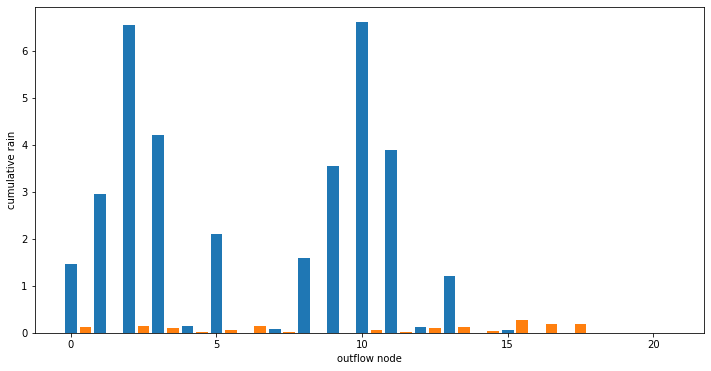

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot bar graph of cumulative rain for each outflow point

fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(111, xlabel='outflow node', ylabel='cumulative rain')
ax1.bar(np.array(range(0,len(outflow_std_mesh))), width=0.4, height=outflow_std_mesh)
ax1.bar(np.array(range(0,len(outflow_rough_mesh)))+0.5, width=0.4, height=outflow_rough_mesh)
plt.show()

In [17]:
## Note, having changed the mesh topography and the related connectivity matrices, 
## the stream power functions immediately reflect the new topology

import lavavu

points = np.column_stack([mesh.tri.points, height])

lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[600,600], near=-10.0)


stream_power_0 = stream_power_fn.evaluate(mesh)
stream_power_a = rbf_smooth_str_power_fn.evaluate(mesh)
stream_power_b = str_smooth_str_power_fn.evaluate(mesh)
stream_power_c = rbf_smooth_str_power_fn2.evaluate(mesh)
stream_power_d = str_smooth_str_power_fn2.evaluate(mesh)


tri1 = lv.triangles("triangles", wireframe=False)
tri1.vertices(points)
tri1.indices(mesh.tri.simplices)
tri1.values(stream_power_0, "stream_power (RAW)")
tri1.values(stream_power_a, "stream_power (RBF 1)")
tri1.values(stream_power_b, "stream_power (STR 1)")
tri1.values(stream_power_c, "stream_power (RBF 2)")
tri1.values(stream_power_d, "stream_power (STR 2)")

tri1.colourmap("drywet")
tri1.colourbar()

lv.control.Panel()
lv.control.ObjectList()
tri1.control.List(options=
                  ["stream_power (RAW)", 
                   "stream_power (RBF 1)",
                   "stream_power (STR 1)", 
                   "stream_power (RBF 2)", 
                   "stream_power (STR 2)", 
                   ], 
                   property="colourby", value="stream_power (RAW)", command="redraw")
lv.control.show()

LavaVu Run error: Failed to open X display




NameError: name 'stream_power_fn' is not defined

The downhill matrices are introduced in the next example, [Ex4-Multiple-downhill-pathways](./Ex4-Multiple-downhill-pathways.ipynb)